# Wprowadzenie

W tym pliku zapoznamy się z strukturą kodu, z którego będziemy korzystać w tych ćwiczeniach.

Najpierw trzeba importować potrzebne biblioteki oraz zadecydować, w jaki sposób będą robione wykresy. W przypadku korzystania z Colaba, należy zakomentować opcję `notebook` i zamiast niej wybrać `inline`.

In [9]:
%matplotlib notebook
# %matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

Poniżej jest podany kod dwu klas, o które będą oparte nasze ćwiczenia: `DifferentialEquation`, reprezentującej równanie różniczkowe, oraz `DifferentialEquationSolution`, reprezentującej rozwiązanie takiego równania. Można się zapoznać z ich implementacją, chociaż nie jest to konieczne.

In [11]:
class DifferentialEquationSolution:
    def __init__(self, equation, solving_function, h = 0.01, title = "Untitled solution", exact = False):
        self.equation = equation
        self.solving_function = solving_function
        self.title = title
        self.exact = exact
        
        self.update(h)
  
    def __repr__(self):
        return f"<{self.title} of {self.equation}>"
    
    def __str__(self):
        return self.title + "\nt: " + str(self.t_list) + "\nx: " + str(self.x_list)
    
    def update(self, h):
        self.h = h
        self.t_list = np.arange(self.equation.t0, self.equation.t_max + h, h)
        self.x_list = self.solving_function(self.t_list, self.equation.f, self.equation.x0)
        
    def update_plot(self):
        self.plot_line.set_data(self.t_list, self.x_list)

In [12]:
class DifferentialEquation:
    def __init__(self, f, x0, t0 = 0, t_max = 1):
        self.f = f
        self.x0 = x0
        self.t0 = t0
        self.t_max = t_max
        self.solutions = []
        
    def add_solution(self, solving_function, h = 0.01, title = "Untitled solution", exact = False):
        solution = DifferentialEquationSolution(self, solving_function, h, title, exact)
        self.solutions.append(solution)
        
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        for solution in self.solutions:
            plot_line, = ax.plot(solution.t_list, solution.x_list, label = solution.title)
            solution.plot_line = plot_line
        
        ax.legend()
        
    def plot_interactive(self, h_min = 0.01, h_max = 1, h_step = 0.01):
        self.plot()
        
        def update(h):
            for solution in self.solutions:
                if not solution.exact:
                    solution.update(h)
                    solution.update_plot()
        
        interact(update, h=(h_min, h_max, h_step));
    
    def _rmse(self, a, b):
        assert np.all(a.t_list == b.t_list), f"Nodes for {a.title} and {b.title} are not the same. Maybe the step (h) is different?"
        a = np.array(a.x_list)
        b = np.array(b.x_list)
        
        return np.sqrt(((a-b)**2).mean())
    
    def measure_rmse(self):
        exact_list = [solution for solution in self.solutions if solution.exact]
        assert len(exact_list) == 1, "There was either no exact solution or multiple exact solutions. Did you use 'exact = True' exactly once?"
        exact_solution = exact_list[0]
        
        rmse_dict = {}
        for solution in self.solutions:
            if solution.exact:
                continue
            rmse = self._rmse(exact_solution, solution)
            rmse_dict[solution.title] = rmse
        return rmse_dict
        

Definiując równanie różniczkowe, musimy podać fukcję $f(t, x)$ oraz wartość $x_0$ taką, że $x(t_0) = x_0$. Również możemy podać wartość $t_0$ (domyślnie ustawione na 0) oraz $t_{max}$ (domyślnie ustawione na 1). 

Rozwiażmy takie zgadnienie Cauchy'ego:
$$ \frac{dx}{dt} = -x + e^{-t}$$
$$ x(0) = 1 $$

dla którego chcemy znaleźć rozwiązanie metodami numerycznymi.

Funkcję $f(t, x)$ wtedy definiujemy w ten sposób:

In [13]:
def sample_f(t, x):
    return -x + np.exp(-t)

I samo równanie stworzymy:

In [29]:
sample_equation = DifferentialEquation(sample_f, x0 = 1, t0 = 0, t_max = 1)

Do równania możemy dodać rozwiązanie dokładne, o ile jest znane, żeby móc porównać dokładność metod numerycznych. W naszym przypadku takie rozwiązanie wynosi:
$$x(t) = e^{-t} + t \cdot e^{-t}$$

I w kodzie go definujemy:

In [30]:
def sample_exact(t, f, x0):
    return np.exp(-t) + t * np.exp(-t)

sample_equation.add_solution(sample_exact, h = 0.05, title = "Exact solution", exact = True)

Należy zwrócić uwagę, że w definicji funkcji `sample_exact` podajemy z powodu implementacji trzy parametry, chociaż korzystamy tylko z `t`. Następnie dodajemy rozwiązanie do naszego równania i definiujemy, że chcemy:
* obliczyć wartość $x$ z krokem 0.05 (ważne dla robienia wykresów)
* nazwać to rozwiązanie "Exact solution"
* zaznaczyć, że chodzi o rozwiązanie dokładne

Warto również zwrócić uwagę, że w `add_solution` podajemy tylko nazwę funkcji bez nawiasów. `sample_exact()` znaczyłoby, że funkcję ma zostać wykonana. W tym przypadku ale przekazujemy _samą funkcję_.

Teraz znajdźmy rozwiązanie metodą łamanych Eulera. Do tego potrzebujemy funkcję, która opisze nam tę metodę:

In [31]:
def euler(t_list, f, x0):
    result = [] # Lista wyników
    result.append(x0) # Wartość x w t0 jest podana
    h = t_list[1] - t_list[0] # Ustalamy krok h
    
    for t in t_list[:-1]: # Idziemy przez wszystkie t
        x_old = result[-1] # Bierzemy ostatnie obliczone x
        x_new = x_old + h * f(t, x_old) # Aplikujemy metodę Eulera
        result.append(x_new) # Dodajemy nowe x na koniec listy
    
    return result # Zwracamy wynik

Samo obliczenie rozwiązania tą metodą przebiega tak samo, jak dodanie rozwiązania dokładnego:

In [32]:
sample_equation.add_solution(euler, h = 0.05, title = "Euler")

Możemy porównać to rozwiązanie z rozwiązaniem dokładnym:

<IPython.core.display.Javascript object>


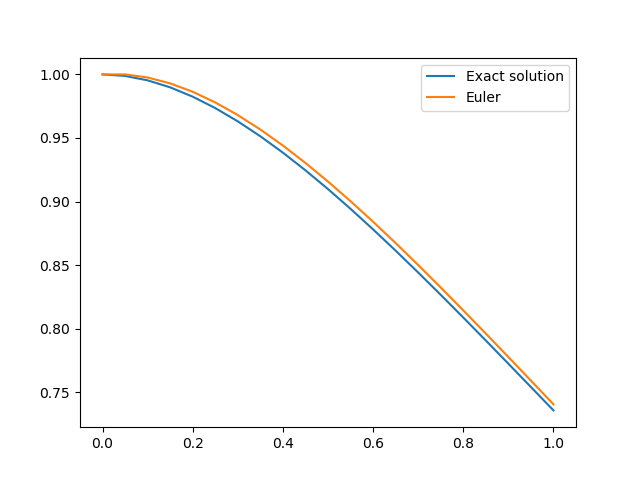

In [33]:
sample_equation.plot()

O ile nie korzystamy z Colaba, możemy również zobaczyć zmianę dokładności rozwiązania w zależności od kroku $h$:

<IPython.core.display.Javascript object>


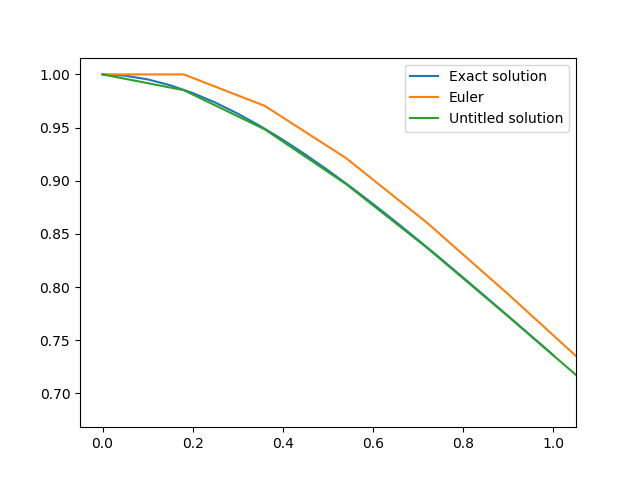

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

In [36]:
sample_equation.plot_interactive()

### Zadanie 1
Analogicznie do metody Eulera podanej powyżej zaimplementuj ulepszoną metodę Eulera. Znajdź z jej pomocą rozwiązanie przybliżone naszego zagadnienia Cauchy'ego i porównaj na wykresie z rozwiązaniem dokładnym oraz rozwiązaniem przybliżonym uzyskanym metodą Eulera. Nie zapomnij o tym, żeby podać taki sam krok, jak w poprzednim przypadku.

<IPython.core.display.Javascript object>


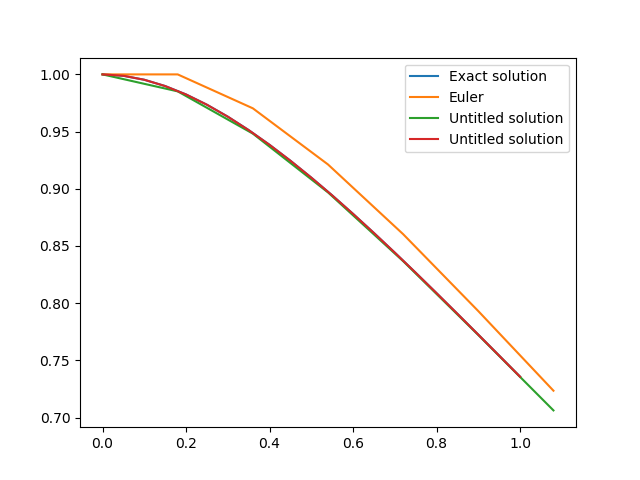

In [37]:
def improved_euler(t_list, f, x0):
    result = []
    result.append(x0)
    h = t_list[1] - t_list[0]
    
    for t in t_list[:-1]:
        ???
    
    return result
